In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('bank/bank-full.csv', sep=';')

# Select relevant columns
columns = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact',
           'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
df = df[columns]


In [15]:
# Convert 'y' column to binary ('yes' -> 1, 'no' -> 0)
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Split the data into train (60%), validation (20%), and test (20%) sets
train_data, temp_data = train_test_split(df, test_size=0.4, random_state=1, stratify=df['y'])
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=1, stratify=temp_data['y'])

# Check the distribution of 'y' in each split
print(train_data['y'].value_counts())
print(validation_data['y'].value_counts())
print(test_data['y'].value_counts())


y
0    23953
1     3173
Name: count, dtype: int64
y
0    7984
1    1058
Name: count, dtype: int64
y
0    7985
1    1058
Name: count, dtype: int64


# Question 1

In [20]:
from sklearn.metrics import roc_auc_score

# Define numerical columns
numerical_columns = ['balance', 'day', 'duration', 'previous']

# Calculate AUC for each numerical variable
for col in numerical_columns:
    auc = roc_auc_score(train_data['y'], train_data[col])
    # Invert the variable if AUC is below 0.5
    if auc < 0.5:
        auc = roc_auc_score(train_data['y'], -train_data[col])
    print(f"AUC for {col}: {auc}")


AUC for balance: 0.5932258557239465
AUC for day: 0.5293292151905477
AUC for duration: 0.8107269279532064
AUC for previous: 0.6023141902708962


# Question 2

In [21]:


# Prepare data for DictVectorizer
train_dict = train_data.drop(columns=['y']).to_dict(orient='records')
val_dict = validation_data.drop(columns=['y']).to_dict(orient='records')

# Initialize and apply DictVectorizer
dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(train_dict)
X_val_encoded = dv.transform(val_dict)

# Target values
y_train = train_data['y']
y_val = validation_data['y']

# Train logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

# Predict on validation set
y_pred_val = model.predict_proba(X_val_encoded)[:, 1]

# Calculate and print AUC
auc_val = roc_auc_score(y_val, y_pred_val)
print(f"AUC on the validation set: {round(auc_val, 3)}")


AUC on the validation set: 0.904


# Question 3

In [26]:


# Define thresholds
thresholds = np.arange(0.0, 0.99, 0.01)

# Lists to store precision and recall values
precision_scores = []
recall_scores = []

# Loop through each threshold and calculate precision and recall
for threshold in thresholds:
    # Apply threshold to predictions
    churn_decision = (y_pred_val >= threshold)
    
    # Calculate precision and recall
    precision = precision_score(y_val, churn_decision)
    recall = recall_score(y_val, churn_decision)
    
    precision_scores.append(precision)
    recall_scores.append(recall)

# Convert lists to arrays for easier plotting
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)


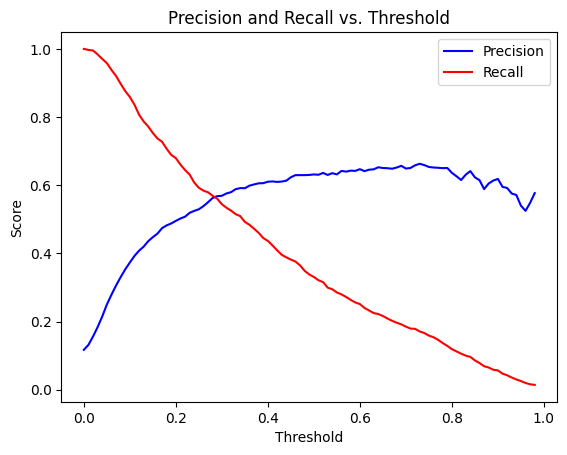

In [27]:
# Plot precision and recall curves
plt.plot(thresholds, precision_scores, label='Precision', color='blue')
plt.plot(thresholds, recall_scores, label='Recall', color='red')

# Add labels and legend
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.show()


In [28]:
# Find the threshold where precision and recall curves intersect
difference = np.abs(precision_scores - recall_scores)
intersection_idx = np.argmin(difference)
intersection_threshold = thresholds[intersection_idx]

print(f"Precision and Recall curves intersect at a threshold of: {intersection_threshold:.2f}")


Precision and Recall curves intersect at a threshold of: 0.28


# question 4

In [29]:
# List to store F1 scores
f1_scores = []

# Compute F1 scores at each threshold
for precision, recall in zip(precision_scores, recall_scores):
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    f1_scores.append(f1)

# Convert list to array for easier manipulation
f1_scores = np.array(f1_scores)


In [30]:
# Find the threshold where F1 is maximal
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]

print(f"Threshold where F1 score is maximal: {max_f1_threshold:.2f}")
print(f"Max F1 score: {f1_scores[max_f1_idx]:.3f}")


Threshold where F1 score is maximal: 0.17
Max F1 score: 0.574


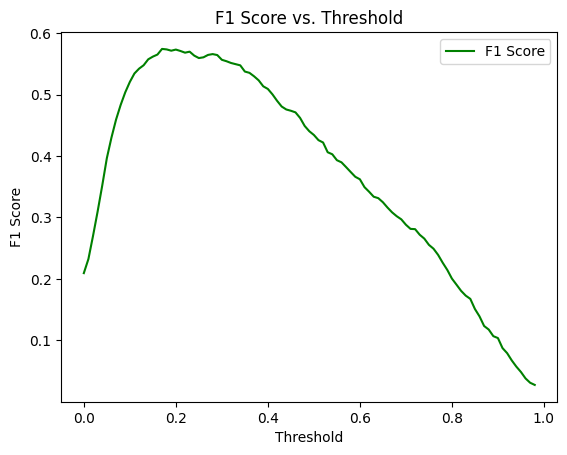

In [31]:
# Plot F1 score against thresholds
plt.plot(thresholds, f1_scores, label='F1 Score', color='green')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()
plt.show()


# question 5

In [35]:
# Assuming you already loaded and split the data earlier

# df_full_train is the combination of the training and validation sets
df_full_train = pd.concat([train_data, validation_data])

# Double-check that df_full_train includes the target variable 'y'
print(df_full_train.head())


       age            job  marital  education  balance housing    contact  \
32664   44    blue-collar  married    primary      228     yes   cellular   
4336    54    blue-collar  married  secondary      233     yes    unknown   
34891   51  self-employed  married    primary      106     yes  telephone   
20655   60        retired  married  secondary      781     yes   cellular   
40601   62        retired  married  secondary        3      no   cellular   

       day month  duration  campaign  pdays  previous poutcome  y  
32664   17   apr       273         1    343         1    other  0  
4336    19   may       220         3     -1         0  unknown  0  
34891    6   may       217         1    169         5  failure  0  
20655   12   aug       128         5     -1         0  unknown  0  
40601    4   aug       151         1     -1         0  unknown  0  


In [37]:

# Prepare the KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# List to store AUC scores for each fold
auc_scores = []

# Loop over the 5 folds
for train_idx, val_idx in kf.split(df_full_train):
    
    # Split the data into train and validation sets
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train['y'].values
    y_val = df_val['y'].values

    # Apply DictVectorizer to one-hot encode the categorical features
    train_dict = df_train.drop(columns=['y']).to_dict(orient='records')
    val_dict = df_val.drop(columns=['y']).to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train_encoded = dv.fit_transform(train_dict)
    X_val_encoded = dv.transform(val_dict)
    
    # Train the logistic regression model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_encoded, y_train)

    # Predict probabilities for validation set
    y_pred_val = model.predict_proba(X_val_encoded)[:, 1]

    # Calculate AUC for this fold
    auc = roc_auc_score(y_val, y_pred_val)
    
    # Append the AUC score to the list
    auc_scores.append(auc)

# Convert AUC scores list to numpy array
auc_scores = np.array(auc_scores)

# Calculate standard deviation of the AUC scores
std_auc = np.std(auc_scores)

print(f"Standard deviation of AUC scores across the folds: {std_auc:.3f}")


Standard deviation of AUC scores across the folds: 0.004


# question 6

In [39]:


# Define the values of C to test
C_values = [0.000001, 0.001, 1]

# Initialize KFold with the same parameters
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Dictionary to store results for each C
results = {}

# Loop over each value of C
for C in C_values:
    auc_scores = []
    
    # 5-Fold cross-validation
    for train_idx, val_idx in kf.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train['y'].values
        y_val = df_val['y'].values
        
        # Convert data to dictionary format and apply DictVectorizer
        train_dict = df_train.drop(columns=['y']).to_dict(orient='records')
        val_dict = df_val.drop(columns=['y']).to_dict(orient='records')

        dv = DictVectorizer(sparse=False)
        X_train_encoded = dv.fit_transform(train_dict)
        X_val_encoded = dv.transform(val_dict)
        
        # Initialize LogisticRegression with current C
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_encoded, y_train)
        
        # Predict probabilities for the validation set
        y_pred_val = model.predict_proba(X_val_encoded)[:, 1]
        
        # Calculate AUC for this fold
        auc = roc_auc_score(y_val, y_pred_val)
        auc_scores.append(auc)
    
    # Compute mean and standard deviation of AUC scores
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    
    # Store the results (rounded to 3 decimal places)
    results[C] = (round(mean_auc, 3), round(std_auc, 3))

# Print the results for each C
for C, (mean_auc, std_auc) in results.items():
    print(f"C={C}: Mean AUC={mean_auc}, Std AUC={std_auc}")

# Find the best C (the one with the highest mean AUC)
best_C = max(results, key=lambda x: results[x][0])
print(f"The best C is: {best_C}, with a mean AUC of {results[best_C][0]}")


C=1e-06: Mean AUC=0.696, Std AUC=0.007
C=0.001: Mean AUC=0.861, Std AUC=0.002
C=1: Mean AUC=0.906, Std AUC=0.004
The best C is: 1, with a mean AUC of 0.906
